In [1]:
%matplotlib inline

In [2]:
# %load diff_coverage.py
from __future__ import division
from scipy.special import comb
from scipy.stats import norm
import os
import numpy as np
import random
from matplotlib import pyplot as plt
import multiprocessing as mp
from sklearn.linear_model import LinearRegression
import json
from read_data import *
import math

def Gaussian_Approx(X, mu, std):
    return -norm.cdf(x=(X-0.5-mu)/std) + norm.cdf(x=(X+0.5-mu)/std)

class Diff_Coverage():

    def __init__(self, uniform=True, f=0, flip_p=0.001, flip_q = 0.1, data_src="SG",
                 plc_num=200,people=500, candidate_num=50, k_favor=5,
                 max_iter=200, stop_iter=200, freeze=False, skew=False):
        # constants in rappor
        self.f = f
        self.p = flip_p
        self.q = flip_q

        # constants in datasets
        self.plc_num = plc_num
        self.k_favor = k_favor
        self.people = people
        self.candidate_num = candidate_num

        # vector, different xi for different place if not uniform
        self.uniform = uniform
        self.xi = None

        self.data_source = data_src


        # constants in iteration
        self.comb_mat = np.load('comb_mat.npy')
        self.iter = max_iter
        # used in greedy random select
        self.stop_iter = stop_iter

        # save to disk
        self.sample_dir = "sample.npy"
        self.transfer_dir = "transfer.npy"

        # paras for regression: a for slope, b for intersect
        # vector, different
        self.a = None
        self.b = None

        self._is_train = False
        self.transferred_sample = None
        self.true_sample = None

        self.freeze = freeze
        self.prob_mat = None
        self.skew = skew

    # make table for combination numbers
    def make_table(self):
        comb_mat = np.zeros((self.candidate_num + 1, self.candidate_num + 1))
        for i in range(0, self.candidate_num + 1):
            for j in range(0, i + 1):
                comb_mat[i][j] = comb(i, j)
        np.save('comb_mat', comb_mat)

    def update_paras(self):
        self.a = np.zeros(self.plc_num)
        self.b = np.zeros(self.plc_num)
        # default is a uniform prior
        self.xi = np.ones(self.plc_num) * self.k_favor / (self.plc_num + 0.0)

    def posterior(self, X, plc_id):
        N = self.candidate_num
        upper_bound = 500
        p_0 = self.p - 0.5 * self.f * (self.p - self.q)
        p_1 = self.q + 0.5 * self.f * (self.p - self.q)

        xi = self.xi[plc_id]
        sum_ = 0
        numerator = p_0 ** X * (1 - p_0) ** (N - X)
        # use Gaussian to approximate Binomial when N is large
        if N > upper_bound:
            mu = N * p_0
            std = math.sqrt(N * p_0 * (1 - p_0))
            numerator *= Gaussian_Approx(X,mu,std)
        else:
            numerator *= self.comb_mat[N, X] * (1 - xi) ** N
        for i in range(0, N + 1):
            if N > upper_bound:
                mu = N * xi
                std = math.sqrt(N * xi * (1 - xi))
                outer = Gaussian_Approx(i, mu, std)
            else:
                outer = self.comb_mat[N, i] * xi ** i * (1 - xi) ** (N - i)
            if outer == 0.0:
                continue
            inner = 0
            for m in range(max([0, X + i - N]), min([i, X]) + 1):
                # sum_ += self.comb_mat[N, i] * self.comb_mat[i, m] * p_1 ** m * (1 - p_1) ** (i - m) * \
                #     self.comb_mat[N - i, X - m] * p_0 ** (X - m) * (1 - p_0) ** (N - i - X + m) * \
                #     xi ** i * (1 - xi) ** (N - i)
                if i <= upper_bound:
                    first_part = self.comb_mat[i, m] * p_1 ** m * (1 - p_1) ** (i - m)
                else:
                    mu = i * (1 - p_1)
                    std = math.sqrt(i * p_1 * (1 - p_1))
                    first_part = Gaussian_Approx(m, mu, std)
                if N - i > upper_bound:
                    mu = (N-i) * p_0
                    std = math.sqrt((N-i) * p_0 * (1 - p_0))
                    second_part = Gaussian_Approx(X-m,mu,std)
                else:
                    second_part = self.comb_mat[N - i, X - m] * p_0 ** (X - m) * (1 - p_0) ** (N - i - X + m)
                # inner += self.comb_mat[i, m] * p_1 ** m * (1 - p_1) ** (i - m) * \
                #         self.comb_mat[N - i, X - m] * p_0 ** (X - m) * (1 - p_0) ** (N - i - X + m)
                inner += first_part * second_part
            sum_ += outer * inner
        ratio = numerator / sum_
        return ratio

    # probability distribution for artificial dataset
    def prob_dist(self):
        plcs = []
        y = np.ones(self.plc_num) * 1.0 / self.plc_num

        prob_mat = np.zeros((self.plc_num, 3))
        prob_mat[:, 0] = np.arange(0, self.plc_num)
        prob_mat[:, 1] = y
        prob_mat[:, 2] = prob_mat[:, 1].cumsum()

        for plc in range(0, self.k_favor):
            in_bit = 1
            while in_bit == 1:
                r = np.random.rand()
                plc_num = prob_mat.shape[0]
                index = -1
                for i in range(0, plc_num - 1):
                    if i == 0:
                        if prob_mat[i, 2] >= r:
                            index = prob_mat[i, 0]
                            break
                    if prob_mat[i, 2] < r and prob_mat[i + 1, 2] >= r:
                        index = prob_mat[i + 1, 0]
                        break
                if index not in plcs:
                    plcs.append(int(index))
                    in_bit = 0
                # else:
                #     print "Same found"
        return plcs

    # read real dataset from different resources
    def real_sample(self, draw=False):
        if self.data_source == "MCS" or "SG" or "CG":
            if self.data_source == "MCS":
                rd = MCS(k_favor=self.k_favor, people=self.people)
                sample = rd.make_grid()
                self.plc_num = rd.plc_num
                # if not self.uniform:
                #     self.xi = np.sum(sample, axis=0) / (0.0 + self.people)
            elif self.data_source == "SG":
                rd = SG(k_favor=self.k_favor, people=self.people, max_id=self.plc_num)
                sample = rd.make_grid()
                # if not self.uniform:
                #     self.xi = np.sum(sample, axis=0) / (0.0 + self.people)
            else:
                rd = CG(k_favor=self.k_favor, people=self.people, max_id=self.plc_num)
                sample = rd.make_grid()
            if self.skew:
                print "Not real dataset, add artificial groups"
                num = int(self.plc_num/self.k_favor)
                full_group = np.zeros((num, self.plc_num))
                for row in range(0,num):
                    full_group[row, range((row-1)*self.k_favor, row*self.k_favor)] = 1
                sample = np.vstack((sample, full_group))
                self.people = sample.shape[0]
            np.save(self.sample_dir, sample)
            print "Total recruit: ", self.people, " from places: ", self.plc_num
            self.update_paras()
            # if not self.uniform:
            #     self.xi = np.sum(sample, axis=0) / (0.0 + self.people)
        else:
            sample = np.zeros((self.people, self.plc_num))

            # skew: add groups of people covering the whole area
            if self.skew:
                partition = [0.2, 0.3, 0.5]
                self.k_favor = self.plc_num / self.candidate_num
                all_plc = list(np.random.permutation(self.plc_num))
                for i in range(0, int(self.people * partition[0])):
                    mod = i % self.candidate_num
                    sample[i,all_plc[mod * self.k_favor: (mod + 1) * self.k_favor]] = 1
                same_k_favor = random.sample(range(self.plc_num), self.k_favor * 5)
                for i in range(int(self.people * partition[0]), int(self.people * partition[1])):
                    small_partition = random.sample(same_k_favor, self.k_favor)
                    sample[i, small_partition] = 1
                for i in range(int(self.people * partition[1]), int(self.people * partition[2])):
                    index = self.prob_dist()
                    sample[i, index] = 1
            else:
                for i in range(0, self.people):
                    index = self.prob_dist()
                    sample[i, index] = np.ones(self.k_favor)
            self.update_paras()
        row_sum = np.sum(sample, axis=0)
        if draw:
            plt.plot(np.arange(0, self.plc_num), row_sum)
            plt.show()
        return sample

    def flip(self, bit):
        r = np.random.rand()
        if r < 0.5 * self.f:
            B_prime = 1
        elif r < self.f:
            B_prime = 0
        else:
            B_prime = bit
        r = np.random.rand()
        if B_prime == 1:
            if r < self.q:
                B = 1
            else:
                B = 0
        else:
            if r < self.p:
                B = 1
            else:
                B = 0
        return B

    # create "fake" dataset after random response
    def transfer_sample(self, draw=False):
        sample = self.real_sample()
        self.true_sample = sample.copy()
        if not self.uniform:
            self.xi = np.sum(self.true_sample, axis=0) / self.people
            self.xi[self.xi == 0] = 1.0 / self.people
        for i in range(0, self.people):
            r = sample[i, :]
            r = np.array(map(lambda bit: self.flip(bit), r))[np.newaxis, :]
            sample[i, :] = r

        row_sum = np.sum(sample, axis=0)
        if draw:
            plt.plot(np.arange(0, self.plc_num), row_sum)
            plt.show()
        self.transferred_sample = sample
        np.save(self.transfer_dir, sample)

    # sum posterior in terms of locations
    def sum_posterior(self, sum_row):
        if self.uniform and self.prob_mat is not None:
            posterior_per_loc = [self.prob_mat[int(x)] for x in sum_row]
        else:
            posterior_per_loc = [self.posterior(int(x), id) for id, x in enumerate(sum_row)]
        total_sum = np.sum(np.array(posterior_per_loc))
        return total_sum

    def train(self, use_grad=False, fake=False):
        if not os.path.exists(self.sample_dir) or \
                not os.path.exists(self.transfer_dir) or not self.freeze:
            self.transfer_sample()
            sample = self.transferred_sample
        else:
            self.transferred_sample = np.load(self.transfer_dir)
            self.true_sample = np.load(self.sample_dir)
            sample = self.transferred_sample
            if not self.uniform and not fake:
                self.update_paras()
                self.xi = np.sum(self.true_sample, axis=0) / self.people
                # self.xi[np.where(self.xi)==0] = 1 / self.people

        # first fit the linear regression coefficients
        self.posterior_regression(draw=False)

        # choice means those ids which are in the candidate set
        choice = random.sample(range(self.people), self.candidate_num)
        not_choice = list(set(range(self.people)).difference(set(choice)))

        # party means the bit arrays for those candidates
        party = sample[choice, :]
        unused = sample[not_choice, :]

        sum_row = np.sum(party, axis=0)
        total_sum = self.sum_posterior(sum_row)
        print "Start Training: Original Loss - " + str(total_sum)

        same_count = 0
        past_set = set()
        for i in range(0, self.iter):

            if use_grad:
                diff, id_of_r, id_of_r_ = self.grad_boosting(
                    sum_row, party, unused)
                r = choice[id_of_r]
                r_ = not_choice[id_of_r_]
                if diff > 0:
                    if {r,r_} == past_set:
                        same_count += 1
                    else:
                        past_set = {r, r_}
                        same_count = 0
                    if same_count >= 3:
                        print "Stop iteration at: ", i
                        break
                    choice[id_of_r] = r_
                    not_choice[id_of_r_] = r
                    party = sample[choice, :]
                    unused = sample[not_choice, :]
                    sum_row = np.sum(party, axis=0)

                    # print 'Loss reduce by: ', str(diff), 'r and r_ is: ', r, r_
                else:
                    break
            else:
                id_of_r = np.random.randint(self.candidate_num)
                r = choice[id_of_r]
                id_of_r_ = random.sample(range(len(unused)), 1)[0]
                r_ = not_choice[id_of_r_]

                sum_row_new = sum_row - party[id_of_r, :] + sample[r_, :]
                total_sum_new = self.sum_posterior(sum_row_new)

                if total_sum_new < total_sum:
                    total_sum = total_sum_new
                    choice[id_of_r] = r_
                    not_choice[id_of_r_] = r
                    party = sample[choice, :]
                    unused = sample[not_choice, :]

                    sum_row = np.sum(party, axis=0)
                    same_count = 0
                else:
                    same_count += 1

                # print str(total_sum), same_count

                if same_count > 1 and use_grad:
                    break
                elif same_count > self.stop_iter:
                    break
        total_sum = self.sum_posterior(sum_row)
        print 'Finish:', total_sum, same_count
        self._is_train = True
        return choice

    # compare with two baseline: use "fake data" directly and greedy random search
    def validate(self, choice, times=10):
        if not self._is_train:
            exit(1)
        # fail = 0
        # abnormal = 0
        true_sample = self.true_sample
        fake_sample = self.transferred_sample

        result = []
        true_opt_party = true_sample[choice, :]
        fake_opt_party = fake_sample[choice, :]
        sum_row = np.sum(fake_opt_party, axis=0)
        total_sum_opt = self.sum_posterior(sum_row)
        coverage_opt = np.sum(np.sum(true_opt_party, axis=0) > 0)
        result.append((coverage_opt, total_sum_opt))
        for i in range(times):
            # totally random pick:
            print "Random Pick"
            rand_choice = random.sample(range(self.people), self.candidate_num)
            true_rand_party = true_sample[rand_choice, :]
            fake_rand_party = fake_sample[rand_choice, :]

            # print out the posterior
            sum_row = np.sum(fake_rand_party, axis=0)
            total_sum_rand = self.sum_posterior(sum_row)
            coverage_rand = np.sum(np.sum(true_rand_party, axis=0) > 0)
            result.append((coverage_rand, total_sum_rand))

            # greedy search
            # print "Rand_Greedy"
            # rand_greedy_choice = self.train(use_grad=False)
            # rand_greedy_party = true_sample[rand_greedy_choice,:]
            # rand_greedy_fake_party = fake_sample[rand_greedy_choice,:]
            #
            # sum_row = np.sum(rand_greedy_fake_party, axis=0)
            # total_sum_rand_greedy = self.sum_posterior(sum_row)
            # coverage_rand_greedy = np.sum(np.sum(rand_greedy_party, axis=0) > 0)
            # result.append((coverage_rand_greedy, total_sum_rand_greedy))

            # take fake as real

            print "Noisy"
            raw_p, raw_q = (self.p, self.q)
            self.p,self.q = (1e-10, 1-1e-10)
            if not self.uniform:
                raw_xi = self.xi
                self.xi = np.sum(fake_sample, axis=0) / self.people
            fake_choice = self.train(use_grad=True,fake=True)
            # print fake_choice
            fake_party = true_sample[fake_choice,:]
            fake_fake_party = fake_sample[fake_choice,:]

            sum_row = np.sum(fake_fake_party, axis=0)
            total_sum_fake = self.sum_posterior(sum_row)
            coverage_fake = np.sum(np.sum(fake_party, axis=0) > 0)
            result.append((coverage_fake, total_sum_fake))
            self.p, self.q = (raw_p, raw_q)
            if not self.uniform:
                self.xi = raw_xi

        # first element is opt, second is random-greedy, third is fake-data
        return result

    # plot random select results to find relationship between loss function and target
    def random_select(self, random_choice=50, file_name='p_0.01'):
        true_sample = np.load(self.sample_dir)
        fake_sample = np.load(self.transfer_dir)
        rand_prob_ = np.zeros(random_choice)
        rand_region_ = np.zeros(random_choice)

        for i in range(0, random_choice):
            self.iter = np.random.randint(1000, 1500)
            self.stop_iter = np.random.randint(50, 100)

            rand_choice = random.sample(range(self.people), self.candidate_num)
            # choice = self.train()
            true_rand_party = true_sample[rand_choice, :]
            fake_rand_party = fake_sample[rand_choice, :]

            # print out the posterior
            sum_row = np.sum(fake_rand_party, axis=0)
            total_sum_rand = self.sum_posterior(sum_row)
            rand_prob_[i] = total_sum_rand
            coverage_rand = np.sum(np.sum(true_rand_party, axis=0) > 0)
            rand_region_[i] = coverage_rand

            if i % 10 == 0:
                print i

        # plt.scatter(real_prob_, real_region,c='r')
        plt.scatter(rand_prob_, rand_region_, c='b')
        plt.xlabel("Sum of posterior over location")
        plt.ylabel("Coverage")
        title = "transfer_prob_=" + str(self.p) + ", candidate_num=" + str(
            self.candidate_num) + ", k_favor=" + str(self.k_favor)
        plt.title(title)
        plt.savefig('img/' + file_name + '.png')
        print self.p, self.k_favor, self.candidate_num

    def posterior_regression(self, draw=False):
        # now coefficients should be a matrix, each place has its own slope and intercept

        # only take several points to fit the linear regression,
        # avoiding high cost of iteration

        # x_max = self.candidate_num + 1
        x_max = 10
        def find_coeffs(plc_id):
            X_range = np.arange(0, x_max)
            stop_count = self.candidate_num + 1
            ans = np.zeros(X_range.shape)
            for X in X_range:
                ans[X] = np.log(self.posterior(X=X, plc_id=plc_id))
                if ans[X] == -np.inf or ans[X] == np.nan:
                    ans[X] = 0
                    stop_count = X
                    break
            X_range = X_range[0:stop_count, np.newaxis]
            ans = ans[0:stop_count, np.newaxis]
            if (draw):
                plt.scatter(X_range, ans)
                plt.show()
            lr = LinearRegression()
            lr.fit(X_range, ans)
            return lr.coef_, lr.intercept_

        if self.uniform:
            # print "Make posterior tables!"
            self.prob_mat = np.array([self.posterior(x,1) for x in range(self.candidate_num + 1)])
            self.prob_mat[np.isnan(self.prob_mat)] = 0
            coeffs = find_coeffs(plc_id=0)
            self.a = np.ones(self.a.shape) * coeffs[0]
            self.b = np.ones(self.b.shape) * coeffs[1]
        else:
            # self.prob_mat = np.zeros((self.plc_num, self.candidate_num + 1))
            # plc with same prior just need one time calculation
            prior_dict = {}

            for plc_id in range(self.plc_num):
                xi_id = int(np.around(self.xi[plc_id] * self.people))
                if prior_dict.has_key(xi_id):
                    # self.prob_mat[plc_id,:] = self.prob_mat[prior_dict[xi_id],:]
                    self.a[plc_id] = self.a[prior_dict[xi_id]]
                    self.b[plc_id] = self.b[prior_dict[xi_id]]
                else:
                    # for x in range(0,self.candidate_num+1):
                    #     self.prob_mat[plc_id, x] = self.posterior(X=x, plc_id=plc_id)
                    prior_dict[xi_id] = plc_id
                    coeffs = find_coeffs(plc_id)
                    self.a[plc_id] = coeffs[0]
                    self.b[plc_id] = coeffs[1]
                # if xi_id == 0:
                #     print self.a[plc_id], self.b[plc_id]
            print "Total different prior: ", len(prior_dict)

        print "Linear Regression over"

    def grad_boosting(self, sum_row, party, unused):

        grad_ = abs(self.a * np.exp(self.b) * np.exp(self.a * sum_row)).T
        candidate_sub = np.dot(party, grad_)
        id_of_r = np.argmin(candidate_sub)

        # re-calculate grad_ using party after removing a candidate
        party[id_of_r,:] = 0
        sum_row = np.sum(party, axis=0)
        grad_ = abs(self.a * np.exp(self.b) * np.exp(self.a * sum_row)).T
        candidate_add = np.dot(unused, grad_)

        # return their sequential id, not original id in sample
        id_of_r_ = np.argmax(candidate_add)

        diff = np.max(candidate_add) - np.min(candidate_sub)
        return diff, int(id_of_r), int(id_of_r_)

def simulate_pipeline(change_k=False, change_p=False, change_cand=False, add_skew=False):
    if change_k:
        changed_paras = range(10,40,10)
        dir_name = 'change_k'
    elif change_p:
        changed_paras = [0.1, 0.01, 0.001]
        dir_name = 'change_p'
    elif change_cand:
        changed_paras = range(40,45,2)
        dir_name = 'change_cand'
    elif add_skew:
        changed_paras = [True, False]
        dir_name = 'add_skew'
    else:
        dir_name = 'test'
        changed_paras = [0]

    try:
        os.listdir(dir_name)
    except OSError:
        os.mkdir(dir_name)

    dataset_num = len(changed_paras)
    iter_per_set = 10

    for i in range(0, dataset_num):
        print "Start a new set!"
        plc_num = 1000
        people = 600
        candidate = 40
        p = 1e-3
        q = 1-p
        k_favor = 25
        skew = True

        if change_k:
            k_favor = changed_paras[i]
        elif change_cand:
            candidate = changed_paras[i]
        elif change_p:
            p = changed_paras[i]
        elif add_skew:
            skew = changed_paras[i]

        new_simulation = Diff_Coverage(flip_p=p, flip_q=q, candidate_num=candidate,
                                       plc_num=plc_num, people=people, k_favor=k_favor, max_iter=4000,
                                       data_src="SG", uniform=False,freeze=True,skew=skew)
        try:
            os.remove(new_simulation.sample_dir)
        except:
            print "No real sample detected!"
        try:
            os.remove(new_simulation.transfer_dir)
        except:
            print "No transferred data detected!"
        # new_simulation.real_sample(draw=True, skew=True, real=False)
        # new_simulation.transfer_sample(draw=False)
        # new_simulation.posterior_regression(draw=True)

        for j in range(0, iter_per_set):
            choice = new_simulation.train(use_grad=True)
            result = new_simulation.validate(choice, times=1)
            print result
            with open(dir_name+ '/' + new_simulation.data_source + '_' +
                      str(i) + '_' + str(j) + ".json", 'w') as f:
                f.write(json.dumps(result))

In [12]:
def easy_draw():
    with open("simu.json",'r') as f:
        d = json.loads(f.read())
    dataset_num = d['dataset_num']
    method_num = d['method_num']
    iter_per_set = d['iter_per_set']
    dir_name = d['dir_name']
    data_src = d['data_src']
    marker = d['change_paras']
    title = d['title']
    
#     marker = ['cand=30','cand=60','cand=90','cand=120']
#     marker = ['k=10','k=20','k=30']
#     marker = ['cand=40','cand=42','cand=44']


    color = ['c','b','r','y','m','k']
    Results = np.zeros((dataset_num, method_num, iter_per_set))
    Stats = np.zeros((dataset_num, method_num, 2))#0 for mean, 1 for std

    for i in range(0, dataset_num):
        for j in range(0, iter_per_set):
            with open(dir_name+ '/' + data_src + '_' +
                      str(i) + '_' + str(j) + ".json",'r') as f:
                results = json.loads(f.read())
                for m in range(0, method_num):
                    Results[i,m,j] = results[m][0]
                    
    for i in range(0,dataset_num):
        for m in range(0, method_num):
            Stats[i,m,0] = np.mean(Results[i,m,:])
            Stats[i,m,1] = np.std(Results[i,m,:])

    print Stats[0,0,1]
    ind = np.arange(dataset_num)
    width = 0.2
    p_list = []
    for m in range(0, method_num):
        if method_num % 2 != 0:
            bias = np.floor(method_num/2)
        else:
            bias = (method_num - 1.0)/2
        p = plt.bar(ind + width*(m-bias), Stats[:,m,0], width=width, color=color[m], yerr=Stats[:,m,1])
        p_list.append(p)
            
    plt.xticks(ind, marker)
    plt.ylim(500,650)
    tup = tuple([p[0] for p in p_list])
    plt.legend(tup,("Greedy", "Noisy","Random"))
    plt.ylabel("Num of Covered Targets")
    plt.savefig(d['pic_name'])
    plt.show()

easy_draw()

IOError: [Errno 2] No such file or directory: 'simu.json'

Present recruit:  1146
Total recruit:  500  from places:  200
Present recruit:  1146
Total recruit:  500  from places:  200


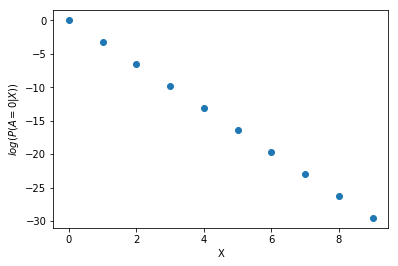

Linear Regression over
